# 

CZII 3D UNET w/Callback, Max Epochs

https://www.kaggle.com/code/stpeteishii/czii-prepare-image-dataset-for-unet

An effective method to find the optimal number of epochs.Save the predicted mask images generated every 3 epoch and try arranging them later. You can see the best number of epochs at a glance. If the epoch number is too large, the mask image will be lost.

In [1]:
# !pip install imantics --quiet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import json
import os
import imantics
from PIL import Image
from skimage.transform import resize
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

2024-12-08 03:40:11.504724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 03:40:11.541201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 03:40:11.541242: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 03:40:11.541301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 03:40:11.551479: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 03:40:11.552109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# GPUが利用可能か確認
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUは利用可能です。認識されているGPU: {[gpu.name for gpu in gpus]}")
else:
    print("GPUが利用されていません。")

GPUが利用されていません。


2024-12-08 03:40:25.400291: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
import tracemalloc
tracemalloc.start()

def print_memory():
    snapshot = tracemalloc.take_snapshot()
    total_memory = sum(stat.size for stat in snapshot.statistics('lineno')) 
    total_memory_mb = total_memory / 1024**2  
    print(f"{total_memory_mb:.2f} MB")


In [4]:
print_memory()

0.02 MB


In [5]:
base_dir = '/kaggle/input/czii-prepare-image-dataset-for-unet'
images_dir = f'{base_dir}/image' 
masks_dir = f'{base_dir}/mask' 
timages_dir = f'{base_dir}/timage' 

In [6]:
images_listdir = os.listdir(images_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [7]:
image_size=512

In [8]:
def read_image(path):
    img = cv2.imread(path)
    #img = cv2.imread(path,cv2.IMREAD_ANYDEPTH)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img, (image_size, image_size))
    #print(img.shape,img2.shape)
    return img2

# Input images 

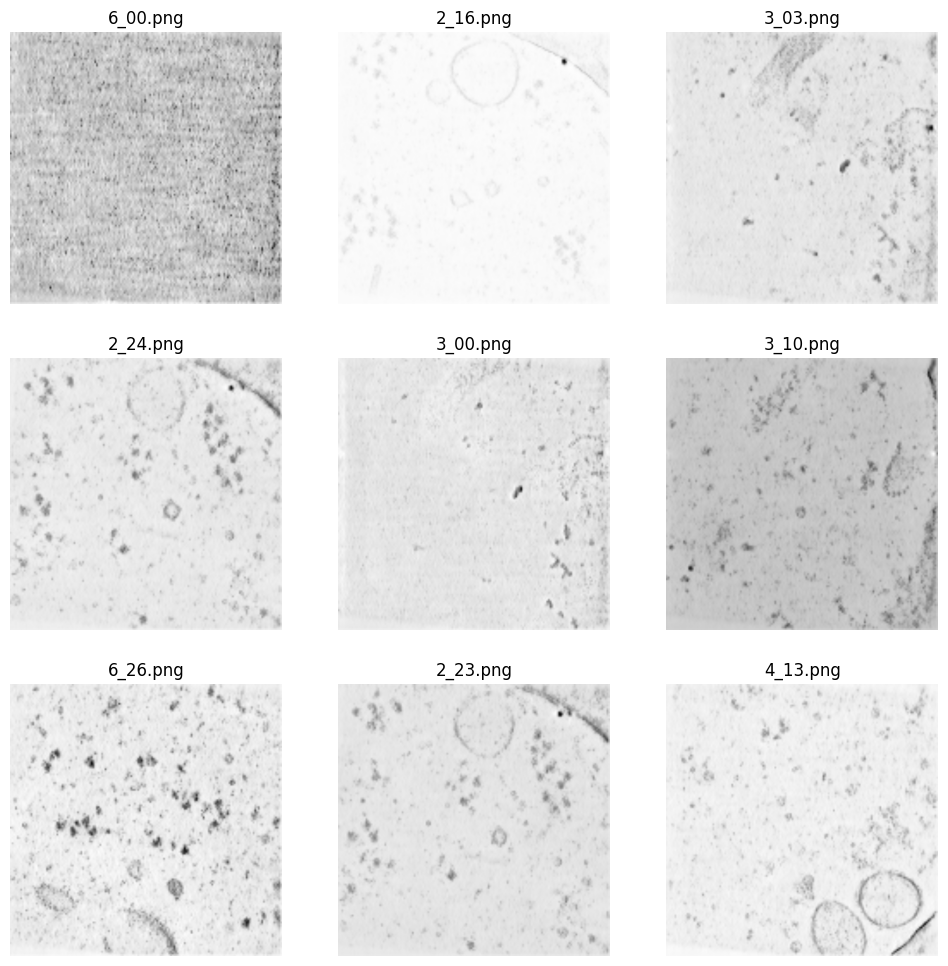

In [9]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (12,12))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

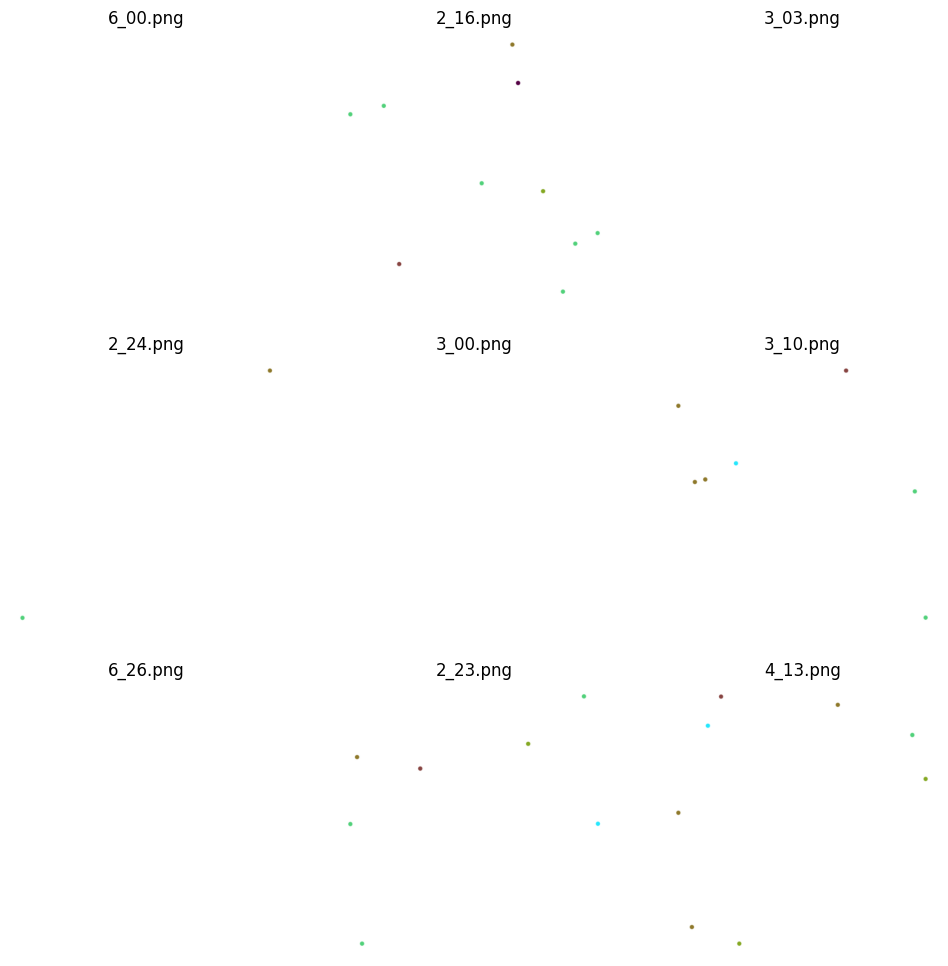

In [10]:
fig, ax = plt.subplots(rows, cols, figsize = (12,12))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file = random_images[i]
        img = read_image(f"{masks_dir}/{file}")       
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

In [11]:
#MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool) 
MASKS=np.zeros((1,image_size,image_size,3),dtype=np.uint8)
IMAGES=np.zeros((1,image_size,image_size,3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:81]): ##the smaller, the faster
    #print(j)
    image = read_image(f"{images_dir}/{file}")
    image_ex = np.expand_dims(image, axis=0)
    IMAGES = np.vstack([IMAGES, image_ex])
    
    file2=file
    mask = read_image(f"{masks_dir}/{file2}")
    #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) #####
    mask_ex = np.expand_dims(mask, axis=0)    
    MASKS = np.vstack([MASKS, mask_ex])

In [12]:
images=np.array(IMAGES)[1:81]
masks=np.array(MASKS)[1:81]
print(images.shape,masks.shape)

(80, 512, 512, 3) (80, 512, 512, 3)


In [13]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [14]:
print(len(images_train), len(masks_train))
print(len(images_test), len(masks_test))

images_train = images_train.reshape(-1, 1, 512, 512, 3)
masks_train = masks_train.reshape(-1, 1, 512, 512, 1) 
images_test = images_test.reshape(-1, 1, 512, 512, 3)
masks_test = masks_test.reshape(-1, 1, 512, 512, 1) 

48 48
32 32


# U-Net

In [15]:
import tensorflow as tf

def print_shape(name, tensor):
    """Shape printing function for debugging"""
    print(f"{name} shape:", tensor.shape)
    return tensor

def encoder_block(input, num_filters, name):
    conv = conv_block(input, num_filters, f"{name}_conv")
    pool = tf.keras.layers.MaxPooling3D((2, 2, 2), strides=(2, 2, 2), padding="same", name=f"{name}_pool")(conv)
    print_shape(f"{name}_conv", conv)
    print_shape(f"{name}_pool", pool)
    return conv, pool

def decoder_block(input, skip, num_filters, name):
    print_shape(f"{name}_input", input)
    print_shape(f"{name}_skip", skip)
    
    # Upsample to match the shape of the skip connection
    target_shape = skip.shape
    current_shape = input.shape
    up_size = (
        target_shape[1] // current_shape[1],
        target_shape[2] // current_shape[2],
        target_shape[3] // current_shape[3]
    )
    
    up = tf.keras.layers.UpSampling3D(size=up_size, name=f"{name}_up")(input)
    print_shape(f"{name}_up", up)
    
    # Concatenate with the skip connection
    concat = tf.keras.layers.Concatenate(axis=-1, name=f"{name}_concat")([up, skip])
    print_shape(f"{name}_concat", concat)
    
    conv = conv_block(concat, num_filters, f"{name}_conv")
    print_shape(f"{name}_conv_out", conv)
    return conv

def conv_block(input, num_filters, name):
    conv = tf.keras.layers.Conv3D(
        num_filters, 3, padding="same", name=f"{name}_conv1")(input)
    conv = tf.keras.layers.BatchNormalization(name=f"{name}_bn1")(conv)
    conv = tf.keras.layers.ReLU(name=f"{name}_relu1")(conv)
    
    conv = tf.keras.layers.Conv3D(
        num_filters, 3, padding="same", name=f"{name}_conv2")(conv)
    conv = tf.keras.layers.BatchNormalization(name=f"{name}_bn2")(conv)
    conv = tf.keras.layers.ReLU(name=f"{name}_relu2")(conv)
    return conv

def Unet3D(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    print_shape("input", inputs)
    
    # Encoder path
    skip1, pool1 = encoder_block(inputs, 64, "encoder1")
    skip2, pool2 = encoder_block(pool1, 128, "encoder2")
    skip3, pool3 = encoder_block(pool2, 256, "encoder3")
    skip4, pool4 = encoder_block(pool3, 512, "encoder4")
    
    # Bridge
    bridge = conv_block(pool4, 1024, "bridge")
    print_shape("bridge", bridge)
    
    # Decoder path
    decode1 = decoder_block(bridge, skip4, 512, "decoder1")
    decode2 = decoder_block(decode1, skip3, 256, "decoder2")
    decode3 = decoder_block(decode2, skip2, 128, "decoder3")
    decode4 = decoder_block(decode3, skip1, 64, "decoder4")
    
    # Output layer
    outputs = tf.keras.layers.Conv3D(
        1, 1, padding="same", activation="sigmoid", name="output")(decode4)
    print_shape("output", outputs)
    
    model = tf.keras.models.Model(inputs, outputs, name="U-Net3D")
    return model


In [16]:
input_shape = (1, 512, 512, 3)  # (depth, height, width, channels)
model = Unet3D(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

input shape: (None, 1, 512, 512, 3)
encoder1_conv shape: (None, 1, 512, 512, 64)
encoder1_pool shape: (None, 1, 256, 256, 64)
encoder2_conv shape: (None, 1, 256, 256, 128)
encoder2_pool shape: (None, 1, 128, 128, 128)
encoder3_conv shape: (None, 1, 128, 128, 256)
encoder3_pool shape: (None, 1, 64, 64, 256)
encoder4_conv shape: (None, 1, 64, 64, 512)
encoder4_pool shape: (None, 1, 32, 32, 512)
bridge shape: (None, 1, 32, 32, 1024)
decoder1_input shape: (None, 1, 32, 32, 1024)
decoder1_skip shape: (None, 1, 64, 64, 512)
decoder1_up shape: (None, 1, 64, 64, 1024)
decoder1_concat shape: (None, 1, 64, 64, 1536)
decoder1_conv_out shape: (None, 1, 64, 64, 512)
decoder2_input shape: (None, 1, 64, 64, 512)
decoder2_skip shape: (None, 1, 128, 128, 256)
decoder2_up shape: (None, 1, 128, 128, 512)
decoder2_concat shape: (None, 1, 128, 128, 768)
decoder2_conv_out shape: (None, 1, 128, 128, 256)
decoder3_input shape: (None, 1, 128, 128, 256)
decoder3_skip shape: (None, 1, 256, 256, 128)
decoder3_up 

Model: "U-Net3D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 512,    │          0 │ -                 │
│ (InputLayer)        │ 512, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_conv_conv1 │ (None, 1, 512,    │      5,248 │ input_layer[0][0] │
│ (Conv3D)            │ 512, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_conv_bn1   │ (None, 1, 512,    │        256 │ encoder1_conv_co… │
│ (BatchNormalizatio… │ 512, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_conv_relu1 │ (None, 1, 512,    │          0 │ encoder1_conv_bn… │
│ (ReLU)              │ 512, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_conv_conv2 │ (None, 1, 512,    │    110,656 │ encoder1_conv_re… │
│ (Conv3D)            │ 512, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_conv_bn2   │ (None, 1, 512,    │        256 │ encoder1_conv_co… │
│ (BatchNormalizatio… │ 512, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_conv_relu2 │ (None, 1, 512,    │          0 │ encoder1_conv_bn… │
│ (ReLU)              │ 512, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder1_pool       │ (None, 1, 256,    │          0 │ encoder1_conv_re… │
│ (MaxPooling3D)      │ 256, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_conv_conv1 │ (None, 1, 256,    │    221,312 │ encoder1_pool[0]… │
│ (Conv3D)            │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_conv_bn1   │ (None, 1, 256,    │        512 │ encoder2_conv_co… │
│ (BatchNormalizatio… │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_conv_relu1 │ (None, 1, 256,    │          0 │ encoder2_conv_bn… │
│ (ReLU)              │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_conv_conv2 │ (None, 1, 256,    │    442,496 │ encoder2_conv_re… │
│ (Conv3D)            │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_conv_bn2   │ (None, 1, 256,    │        512 │ encoder2_conv_co… │
│ (BatchNormalizatio… │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_conv_relu2 │ (None, 1, 256,    │          0 │ encoder2_conv_bn… │
│ (ReLU)              │ 256, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder2_pool       │ (None, 1, 128,    │          0 │ encoder2_conv_re… │
│ (MaxPooling3D)      │ 128, 128)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder3_conv_conv1 │ (None, 1, 128,    │    884,992 │ encoder2_pool[0]… │
│ (Conv3D)            │ 128, 256)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder3_conv_bn1   │ (None, 1, 128,    │      1,024 │ encoder3_conv_co

 Total params: 94,148,481 (359.15 MB)

 Trainable params: 94,136,705 (359.10 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [17]:
print_memory()

393.68 MB


# Callback

In [18]:
#!rm -rf output_masks

In [19]:
from tensorflow import keras

import numpy as np
import keras

class SaveMaskImagesCallback(keras.callbacks.Callback):
    def __init__(self, test_images, output_dir):
        super().__init__()
        self.test_images = test_images
        self.output_dir = output_dir
        
    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.test_images)
        for i, pred_mask in enumerate(predictions):
            # Squeeze out extra dimensions to get shape (512, 512, 1)
            pred_mask = np.squeeze(pred_mask)
            # Add channel dimension back if needed
            if pred_mask.ndim == 2:
                pred_mask = pred_mask[..., np.newaxis]
                
            output_path = os.path.join(self.output_dir, f"mask_{i:02d}_ep_{epoch + 1:03d}.png")
            pred_mask = (pred_mask * 255).astype(np.uint8)
            keras.preprocessing.image.save_img(output_path, pred_mask)
            
output_directory = "output_masks"  
os.makedirs(output_directory, exist_ok=True)
mask_callback = SaveMaskImagesCallback(images_train, output_directory) 

In [20]:
images_train.shape

(48, 1, 512, 512, 3)

In [21]:
masks_train.shape

(144, 1, 512, 512, 1)

In [22]:
images_test.shape

(32, 1, 512, 512, 3)

In [23]:
print_memory()

393.78 MB


# Train

In [24]:
unet_result = model.fit(
    images_train, masks_train, 
    validation_split=0.2, batch_size=1, epochs=30,
    callbacks=[mask_callback]
)

Epoch 1/30


I0000 00:00:1731725898.600236      90 service.cc:145] XLA service 0x7b47d40022d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731725898.600297      90 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731725898.600301      90 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-16 02:58:27.262282: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng5{} for conv (f32[1,64,1,512,512]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,1,512,512]{4,3,2,1,0}, f32[64,64,3,3,3]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-16 02:58:27.718381: E ex

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 2.2935e-05 - loss: -405.9931

2024-11-16 03:00:21.294395: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=2,k3=0} for conv (f32[32,64,1,512,512]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,1,512,512]{4,3,2,1,0}, f32[64,64,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-16 03:00:23.402632: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.10841628s
Trying algorithm eng11{k2=2,k3=0} for conv (f32[32,64,1,512,512]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,1,512,512]{4,3,2,1,0}, f32[64,64,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasAc

1/2 ━━━━━━━━━━━━━━━━━━━━ 1:28 88s/step

2024-11-16 03:02:02.381775: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=2,k3=0} for conv (f32[16,64,1,512,512]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,1,512,512]{4,3,2,1,0}, f32[64,64,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-16 03:02:02.943819: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.562174404s
Trying algorithm eng11{k2=2,k3=0} for conv (f32[16,64,1,512,512]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,1,512,512]{4,3,2,1,0}, f32[64,64,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasA

2/2 ━━━━━━━━━━━━━━━━━━━━ 147s 59s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 306s 6s/step - accuracy: 2.2911e-05 - loss: -410.9716 - val_accuracy: 0.0000e+00 - val_loss: 58680800.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 2.4980e-05 - loss: -926.4311 - val_accuracy: 0.0000e+00 - val_loss: 154196768.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 1.8348e-05 - loss: -1245.3127 - val_accuracy: 9.9182e-06 - val_loss: 176800.7031
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 2.7469e-05 - loss: -1610.6348 - val_accuracy: 9.9182e-06 - val_loss: -12461.3271
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 1.4169e-05 - loss: -2021.6320 - val_accuracy: 9.9182e-06 - val_loss: -2163.8079
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 1.

In [25]:
unet_result

In [26]:
print_memory()

413.39 MB


# Predict

In [27]:
unet_predict = model.predict(images_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [28]:
def show_result(idx, og, unet, target, p):

    print(unet.flatten().min(),unet.flatten().max())
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx))
    axs[0].imshow(og.squeeze())
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet.squeeze()*255)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target.squeeze())
    axs[2].axis('off')

    plt.show()

In [29]:
r1,r2,r3,r4=0.7,0.8,0.9,0.99

In [30]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

1 1


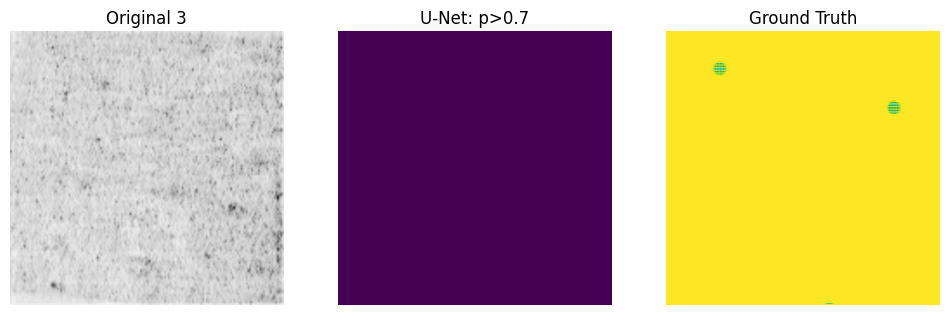

1 1


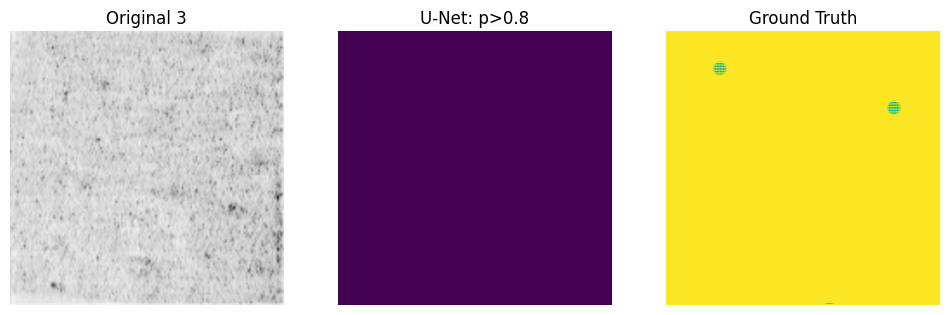

1 1


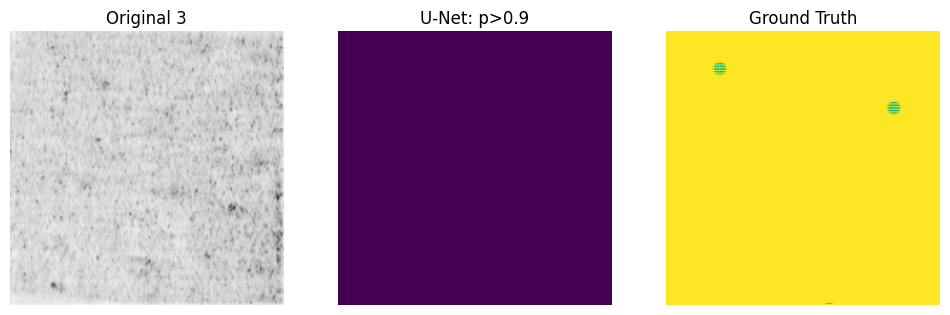

1 1


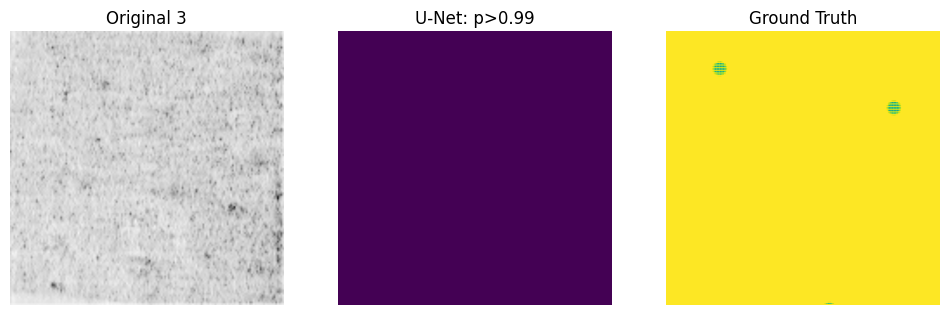


1 1


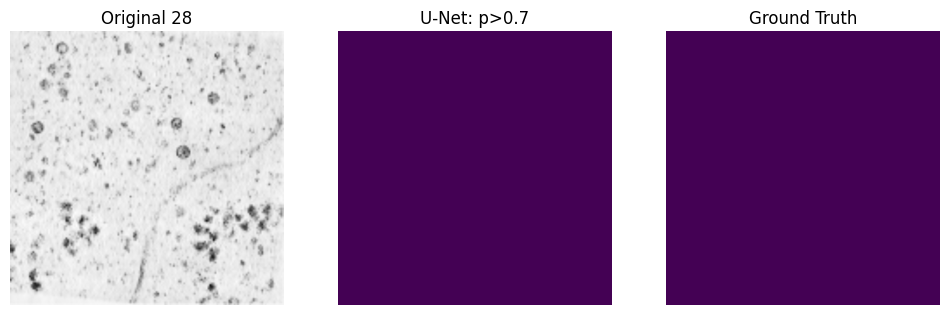

1 1


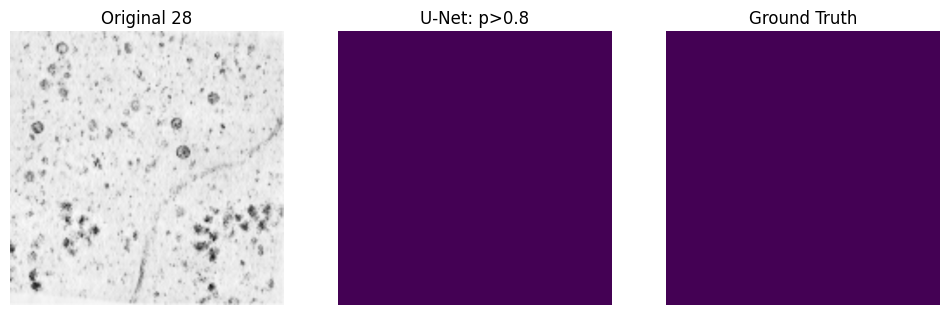

1 1


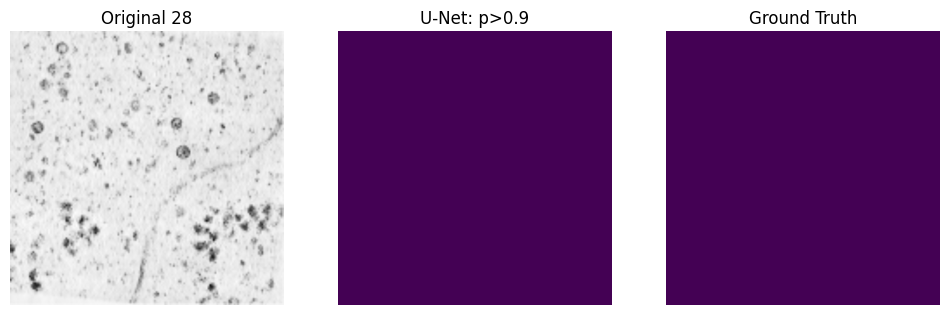

1 1


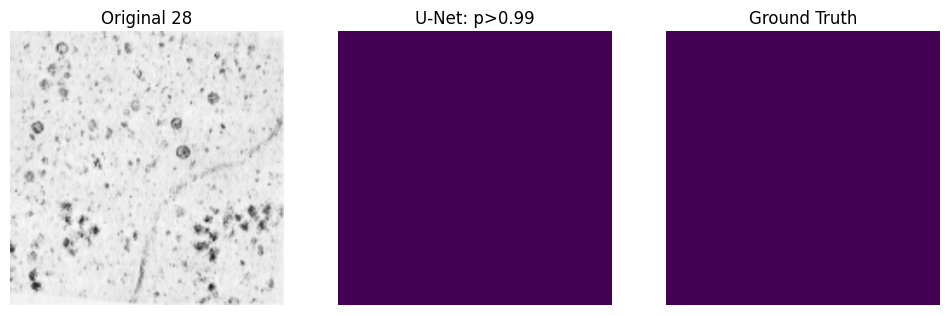


1 1


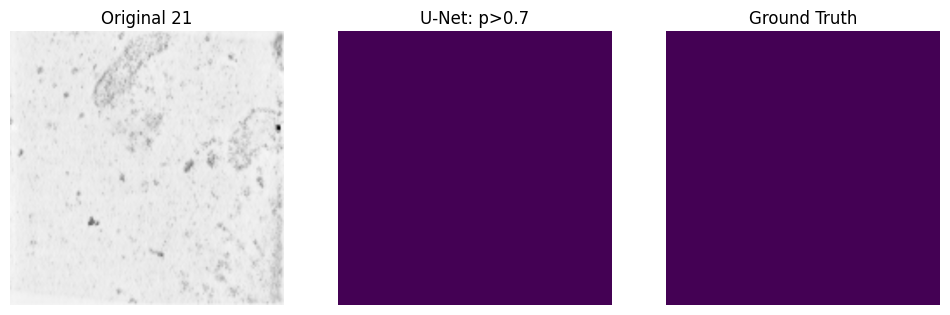

1 1


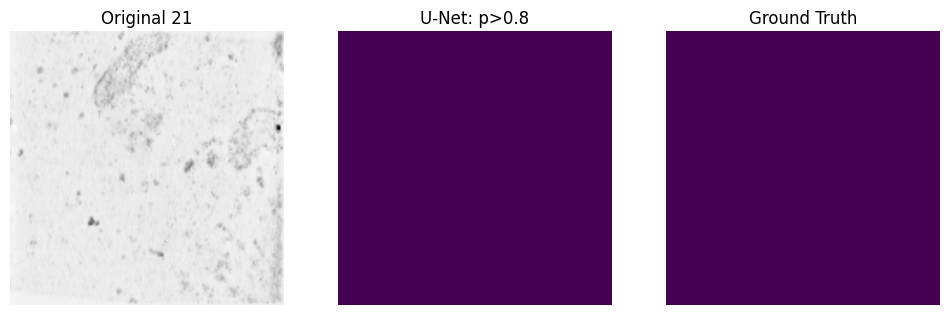

1 1


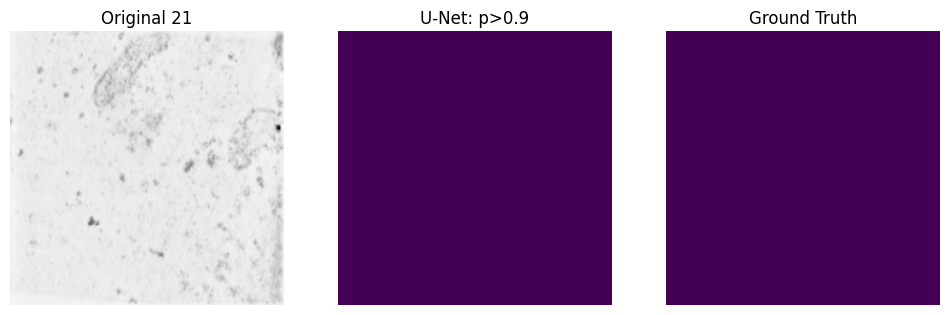

1 1


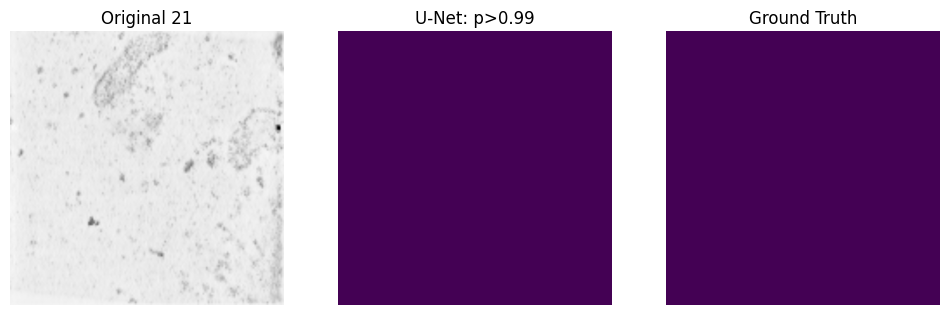

In [31]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

In [32]:
print_memory()

508.66 MB
